# Anthropogenic heat from human metabolism

This notebook is used to process population data, and ultimately produce the anthropogenic heat flux (AHF) from human metabolism for the Greater Los Angeles (LA) region.

## Todos

- remove redundancy (e.g., making one pipeline for any year ACS data)
- create any necessary functions
- "rasterize" final census tract based shapefile to 100m grid

In [1]:
# load packages 
%matplotlib inline
import os
import glob
from pathlib import Path
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
#import requests
import geopandas as gpd
import pyproj
import shapely.geometry
import contextily as ctx
from matplotlib.ticker import FormatStrFormatter
import geofeather
import dask_geopandas as dgpd
import pyogrio
import folium
import numpy as np

In [2]:
# define paths to data
acs_folder = Path('/Users/josephko/USC/Research/Anthropogenic Heat/census/acs')
ctpp_folder = Path('/Users/josephko/USC/Research/Anthropogenic Heat/census/ctpp')
bounds_folder = Path('/Users/josephko/USC/Research/Anthropogenic Heat/boundaries')

## Using 2012-2016 ACS Data

NOTE: There is an issue with the 2012-2016 CTPP workers data. The county aggregated total does not match up the sum of census tract aggregated total workers. This is due to the fact that a large fraction of the workers could not be accurately geocached to the census tract level. See https://ctpp.transportation.org/ctpp-data-set-information/known-data-issues/ for more details.

Import data: 

In [3]:
# import Census-based ACS data and CTPP data
"""
ACS = american community survey
CTPP = census transportation planning products program
- CTPP data is derived from ACS data
- 5-yr data (2012-2016) is used
- all data below is aggregated to census tract
"""
# import total population (from ACS table B01003)
total_pop_path = acs_folder / 'ACSDT5Y2016.B01003_2022-04-18T013603' / 'ACSDT5Y2016.B01003_data_clean.csv'
total_pop = pd.read_csv(total_pop_path)

# import total workers living in area (from ACS table B08008)
total_workers_living_path = acs_folder / 'ACSDT5Y2016.B08008_2022-04-18T115010' / 'ACSDT5Y2016.B08008_data_clean.csv'
total_workers_living = pd.read_csv(total_workers_living_path)

# import total workers working in area (from CTPP)
total_workers_working_path = ctpp_folder / 'total_workers_lacounty_tract.csv'
total_workers_working = pd.read_csv(total_workers_working_path, dtype = 'string')

# import california census tracts shapefile
tract_bounds_path = bounds_folder / 'ca_2016_census_tracts.zip'
tract_bounds = gpd.read_file(tract_bounds_path)

Clean and alter data:

In [4]:
# remove catalina island and avalon from census tracts
tract_bounds.drop(tract_bounds.loc[(tract_bounds.NAME == '5990') | (tract_bounds.NAME == '5991')].index, inplace=True)

# convert to appropriate data types

# first get rid of commas and convert to float
total_workers_working['Estimate'] = total_workers_working['Estimate'].str.replace(',', '').astype(float)
total_workers_working['Margin of Error'] = total_workers_working['Margin of Error'].str.replace(',', '').astype(float)

# # then convert to int
# total_workers_working['Estimate'] = total_workers_working['Estimate'].astype('Int64')
# total_workers_working['Margin of Error'] = total_workers_working['Margin of Error'].astype('Int64')

# rename columns of dataframes for further merging 
total_workers_working.rename(columns={'WORKPLACE':'NAME'}, inplace=True)

tract_bounds.rename(columns={'AFFGEOID':'GEO_ID'}, inplace=True)

# merge 'total population' with 'total workers living in area'
cols_to_use = total_workers_living.columns.difference(total_pop.columns).to_list()
cols_to_use.append('GEO_ID')
total_pop_merge_workers_living = total_pop.merge(total_workers_living[cols_to_use], on = 'GEO_ID', how = 'inner')

# continue merging with 'total workers working in area'
total_pop_workers_living_working = total_pop_merge_workers_living.merge(total_workers_working, on='NAME', how='inner')

# final merge with census tract boundaries
final_merged_gdf = tract_bounds.merge(total_pop_workers_living_working, on='GEO_ID', how='right')


# """
# Note: The final_merged_gdf has two less records because Census tracts 9901 and 9902 are dropped. 
# - these census tracts have populations of zero
# - likely census tracts off the coast and therefore not included in the original CA census tracts shapefile
# """
# # final_merged_gdf.shape
# # final_merged_gdf[final_merged_gdf.geometry==None]
# # total_pop[total_pop.GEO_ID == '1400000US06037990200']

# rename columns to be more readable
final_merged_gdf.rename(columns={'B01003_001E':'pop_night','Estimate':'n_workers_working', 'B08008_001E':'n_workers_living'}, inplace=True)

Calculate and plot:

In [5]:
# calculate daytime adjusted population
"""
https://www.census.gov/topics/employment/commuting/guidance/calculations.html
Method 2: Total resident population + Total workers working in area - Total workers living in area
 -> 'pop_night' + 'n_workers_working' - 'n_workers_living'
"""
final_merged_gdf['pop_day'] = final_merged_gdf['pop_night'] + final_merged_gdf['n_workers_working'] - final_merged_gdf['n_workers_living']

# calculate population densities (day and night)
final_merged_gdf['area'] = final_merged_gdf.geometry.to_crs('EPSG:3310').area
final_merged_gdf['pop_density_night'] = (final_merged_gdf['pop_night']/final_merged_gdf['area'])*(10**6)
final_merged_gdf['pop_density_day'] = (final_merged_gdf['pop_day']/final_merged_gdf['area'])*(10**6)

# calculate weighted pop density
final_merged_gdf['pop_density_night_weighted'] = (final_merged_gdf['area']*final_merged_gdf['pop_density_night'])/(final_merged_gdf['area'].sum())
final_merged_gdf['pop_density_day_weighted'] = (final_merged_gdf['area']*final_merged_gdf['pop_density_day'])/(final_merged_gdf['area'].sum())

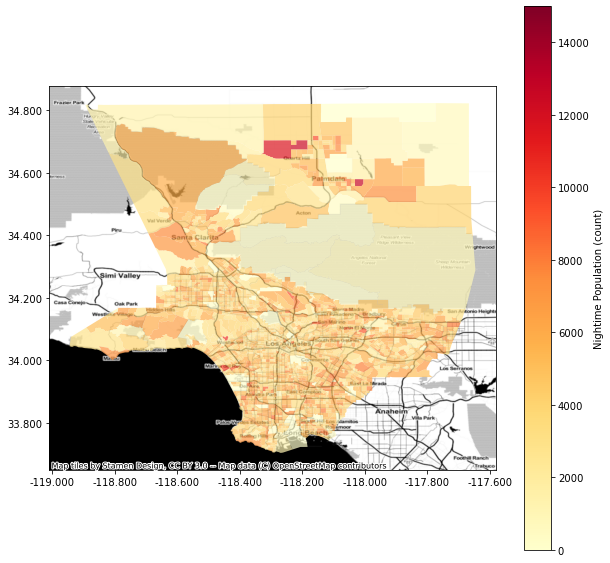

In [6]:
# map night-time (residential) population 
ax = final_merged_gdf.plot(figsize=(10,10), column='pop_night', alpha=0.7, 
                           legend=True, cmap='YlOrRd', 
                           vmin = 0, vmax = 15000,
                           legend_kwds={'label':'Nightime Population (count)'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

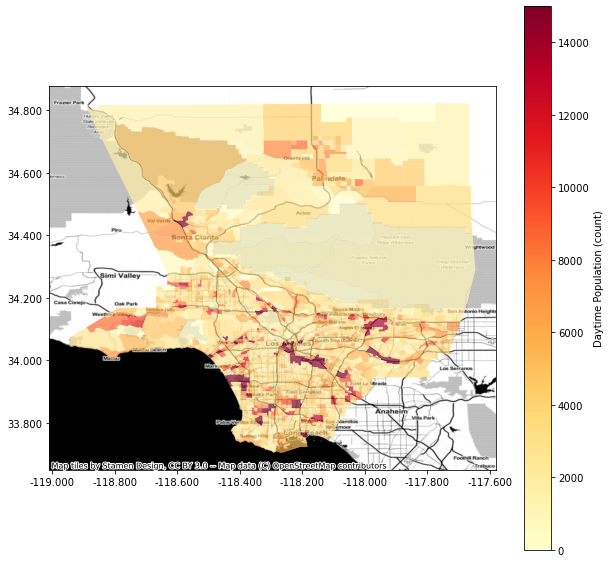

In [7]:
# map daytime-time (commute-adjusted) population 
ax = final_merged_gdf.plot(figsize=(10,10), column='pop_day', alpha=0.7, 
                           legend=True, cmap='YlOrRd', 
                           vmin = 0, vmax = 15000,
                           legend_kwds={'label':'Daytime Population (count)'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

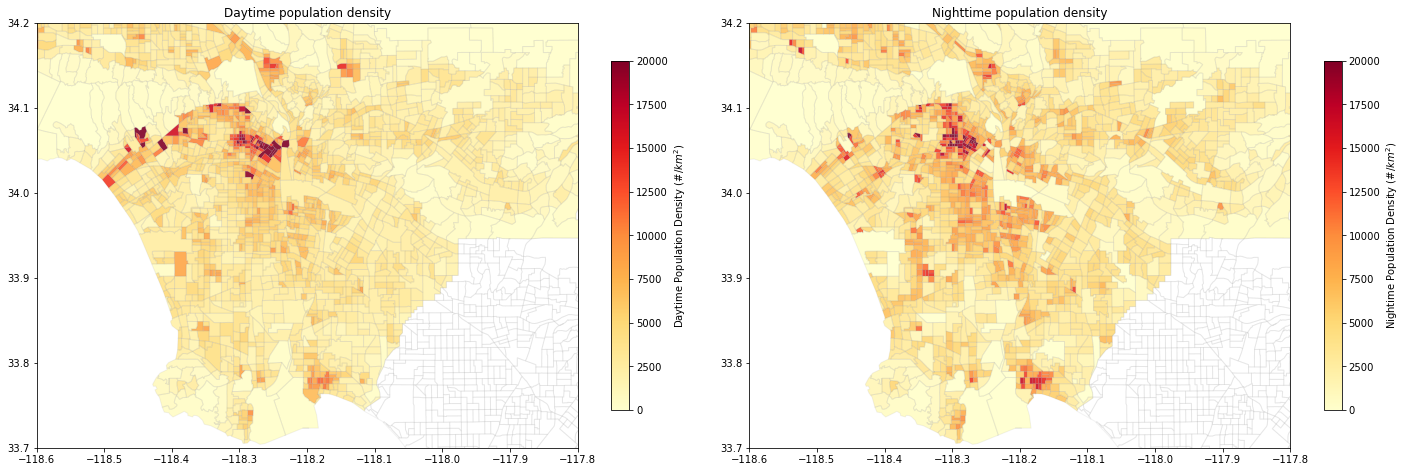

In [8]:
# plot population densities (day and night)
fig, axes = plt.subplots(figsize=(20, 10), ncols=2, nrows=1)
final_merged_gdf.plot(ax=axes[0], column='pop_density_day', alpha=0.9, 
                           legend=True, cmap='YlOrRd', 
                           vmin = 0, vmax = 20000,
                           legend_kwds={'label':'Daytime Population Density (#/$km^2$)',
                                       'shrink':0.5})
tract_bounds.plot(ax=axes[0], figsize=(10,10), alpha=0.1, facecolor = 'none', edgecolor='gray')
#ctx.add_basemap(axes[0], source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
final_merged_gdf.plot(ax=axes[1], column='pop_density_night', alpha=0.9, 
                           legend=True, cmap='YlOrRd', 
                           vmin = 0, vmax = 20000,
                           legend_kwds={'label':'Nightime Population Density (#/$km^2$)',
                                       'shrink':0.5})
tract_bounds.plot(ax=axes[1], figsize=(10,10), alpha=0.1, facecolor = 'none', edgecolor='gray')
#ctx.add_basemap(axes[1], source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
axes[0].set_title("Daytime population density")
axes[1].set_title("Nighttime population density")
axes[0].set_xlim(-118.6, -117.8)
axes[0].set_ylim(33.7, 34.2)
axes[1].set_xlim(-118.6, -117.8)
axes[1].set_ylim(33.7, 34.2)
fig.tight_layout()

Basic checks:


In [9]:
# total population density of LA county (not including catalina island and avalon)
final_merged_gdf['pop_density_night_weighted'].sum()

978.4155970993215

In [257]:
# check that the sum day and night populations match
sum_pop_day = final_merged_gdf['pop_day'].sum()
sum_pop_night = final_merged_gdf['pop_night'].sum()
print('Daytime population = ', sum_pop_day)
print('Nighttime population = ', sum_pop_night)

Daytime population =  8996735.0
Nighttime population =  10057155


In [263]:
final_merged_gdf.n_workers_living.sum()

4591360

In [264]:
final_merged_gdf.n_workers_working.sum()

3530940.0

In [260]:
"""
Check using county aggregated numbers 
https://www.census.gov/topics/employment/commuting/guidance/calculations.html
Method 2: Total resident population + Total workers working in area - Total workers living in area
 -> 'pop_night' + 'n_workers_working' - 'n_workers_living'
"""
# Total workers living in LA County (B08008)
workers_living_la = 4591360
 
# Total workers working in LA County (CTTP)
workers_working_la = 4730905

# total resident population in LA County (B01003)
residents_la = 10038388

# calculate commute-adjusted population (daytime population) 
daytime_pop_la = residents_la + workers_working_la - workers_living_la
print('total daytime pop of LA = ', daytime_pop_la)
print('total nighttime pop of LA = ', residents_la)

total daytime pop of LA =  10177933
total nighttime pop of LA =  10038388


!!!NOTE!!! </br>
There is a discrepancy in the ACS data for these years. In short, the daytime population turns out to be less than the nighttime population, which does not make sense. This is due to missing workers in the data. </br> 
</br>
Email from AASHTO staff:

Hi Joseph,

 

If you head over to: https://ctpp.transportation.org/ctpp-data-set-information/known-data-issues/ and look at the resources for missing workers you will have a lot more info and some tools to help reconcile.  The previous data did have a synthetic allocation process, census research found that it created more inaccuracy than they were comfortable with.  About 25% of workers cannot be geocoded. The Census imputes them to the county but not below.  This is why your tracts don’t add up.

 

Feel free to reach out if you have more questions after you have looked at the materials.

 

Penelope

## Using 2006-2010 ACS Data

import data:

In [10]:
# import Census-based ACS data and CTPP data
"""
ACS = american community survey
CTPP = census transportation planning products program
- CTPP data is derived from ACS data
- 5-yr data (2006-2010) is used
- all data below is aggregated to census tract
"""
# import total population (from ACS table B01003)
total_pop_path = acs_folder / 'ACSDT5Y2010.B01003_2022-04-19T103125' / 'ACSDT5Y2010.B01003_data_clean.csv'
total_pop = pd.read_csv(total_pop_path)

# import total workers living in area (from ACS table B08008)
total_workers_living_path = acs_folder / 'ACSDT5Y2010.B08008_2022-04-19T103032' / 'ACSDT5Y2010.B08008_data_clean.csv'
total_workers_living = pd.read_csv(total_workers_living_path)

# import total workers working in area (from CTPP)
total_workers_working_path = ctpp_folder / 'total_workers_lacounty_tract_2010.csv'
total_workers_working = pd.read_csv(total_workers_working_path, dtype = 'string')

# import california census tracts shapefile
tract_bounds_path = bounds_folder / 'ca_2010_census_tracts.zip'
tract_bounds = gpd.read_file(tract_bounds_path)

clean and edit data:

In [11]:
# remove catalina island and avalon from census tracts
tract_bounds.drop(tract_bounds.loc[(tract_bounds.NAME == '5990') | (tract_bounds.NAME == '5991')].index, inplace=True)

# === convert to appropriate data types ===

# first get rid of commas and convert to float
total_workers_working['Estimate'] = total_workers_working['Estimate'].str.replace(',', '').astype(float)
total_workers_working['Margin of Error'] = total_workers_working['Margin of Error'].str.replace(',', '').astype(float)

# # then convert to int
# total_workers_working['Estimate'] = total_workers_working['Estimate'].astype('Int64')
# total_workers_working['Margin of Error'] = total_workers_working['Margin of Error'].astype('Int64')

# rename columns of dataframes for further merging 
total_workers_working.rename(columns={'WORKPLACE':'NAME'}, inplace=True)

tract_bounds.rename(columns={'AFFGEOID':'GEO_ID'}, inplace=True)

# merge 'total population' with 'total workers living in area'
cols_to_use = total_workers_living.columns.difference(total_pop.columns).to_list()
cols_to_use.append('GEO_ID')
total_pop_merge_workers_living = total_pop.merge(total_workers_living[cols_to_use], on = 'GEO_ID', how = 'inner')

# continue merging with 'total workers working in area'
total_pop_workers_living_working = total_pop_merge_workers_living.merge(total_workers_working, on='NAME', how='inner')

# final merge with census tract boundaries
final_merged_gdf = tract_bounds.merge(total_pop_workers_living_working, on='GEO_ID', how='right')

# rename columns to be more readable
final_merged_gdf.rename(columns={'B01003_001E':'pop_night','Estimate':'n_workers_working', 'B08008_001E':'n_workers_living'}, inplace=True)


calculations:

In [12]:
# calculate daytime adjusted population
"""
https://www.census.gov/topics/employment/commuting/guidance/calculations.html
Method 2: Total resident population + Total workers working in area - Total workers living in area
 -> 'pop_night' + 'n_workers_working' - 'n_workers_living'
"""
final_merged_gdf['pop_day'] = final_merged_gdf['pop_night'] + final_merged_gdf['n_workers_working'] - final_merged_gdf['n_workers_living']

# calculate population densities (day and night)
final_merged_gdf['area'] = final_merged_gdf.geometry.to_crs('EPSG:3310').area
final_merged_gdf['pop_density_night'] = (final_merged_gdf['pop_night']/final_merged_gdf['area'])*(10**6)
final_merged_gdf['pop_density_day'] = (final_merged_gdf['pop_day']/final_merged_gdf['area'])*(10**6)

# calculate weighted pop density
final_merged_gdf['pop_density_night_weighted'] = (final_merged_gdf['area']*final_merged_gdf['pop_density_night'])/(final_merged_gdf['area'].sum())
final_merged_gdf['pop_density_day_weighted'] = (final_merged_gdf['area']*final_merged_gdf['pop_density_day'])/(final_merged_gdf['area'].sum())

sanity check:

In [13]:
# check that the sum day and night populations match
sum_pop_day = final_merged_gdf['pop_day'].sum()
sum_pop_night = final_merged_gdf['pop_night'].sum()
print('Daytime population = ', sum_pop_day)
print('Nighttime population = ', sum_pop_night)

Daytime population =  9890402.0
Nighttime population =  9758256


plot:

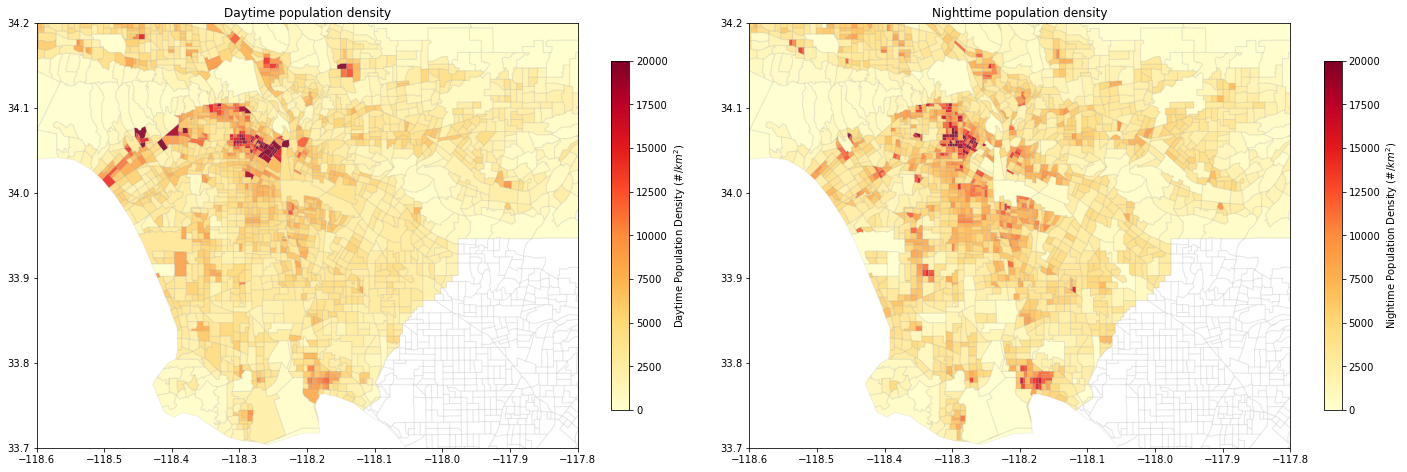

In [14]:
# plot population densities (day and night)
fig, axes = plt.subplots(figsize=(20, 10), ncols=2, nrows=1)
final_merged_gdf.plot(ax=axes[0], column='pop_density_day', alpha=0.9, 
                           legend=True, cmap='YlOrRd', 
                           vmin = 0, vmax = 20000,
                           legend_kwds={'label':'Daytime Population Density (#/$km^2$)',
                                       'shrink':0.5})
tract_bounds.plot(ax=axes[0], figsize=(10,10), alpha=0.1, facecolor = 'none', edgecolor='gray')
#ctx.add_basemap(axes[0], source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
final_merged_gdf.plot(ax=axes[1], column='pop_density_night', alpha=0.9, 
                           legend=True, cmap='YlOrRd', 
                           vmin = 0, vmax = 20000,
                           legend_kwds={'label':'Nightime Population Density (#/$km^2$)',
                                       'shrink':0.5})
tract_bounds.plot(ax=axes[1], figsize=(10,10), alpha=0.1, facecolor = 'none', edgecolor='gray')
#ctx.add_basemap(axes[1], source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
axes[0].set_title("Daytime population density")
axes[1].set_title("Nighttime population density")
axes[0].set_xlim(-118.6, -117.8)
axes[0].set_ylim(33.7, 34.2)
axes[1].set_xlim(-118.6, -117.8)
axes[1].set_ylim(33.7, 34.2)
fig.tight_layout()

In [15]:
final_merged_gdf.to_file('./data/output/population_by_tract.shp')

/Users/josephko/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/4m/_rb2pz1d7jx9ywsn916lhr_c0000gn/T/ipykernel_64312/746369742.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_merged_gdf.to_file('./data/output/population_by_tract.shp')


In [273]:
# Create animation of night to day transition
# using a hacky temporal interpolation method using averages
# create 5 time steps (e.g., 6am - 10am or 3pm - 7pm)
final_merged_gdf['t_0'] = final_merged_gdf['pop_density_night']
final_merged_gdf['t_4'] = final_merged_gdf['pop_density_day']
final_merged_gdf['t_2'] = final_merged_gdf[['t_0', 't_4']].mean(axis=1)
final_merged_gdf['t_1'] = final_merged_gdf[['t_2', 't_0']].mean(axis=1)
final_merged_gdf['t_3'] = final_merged_gdf[['t_4', 't_2']].mean(axis=1)

In [280]:
# loop through columns t_0 to t_4 and save each plot as png
for i in range(5):
    column_name = "t_" + str(i)
    
    # plot
    fig, axes = plt.subplots(figsize=(20, 10))
    final_merged_gdf.plot(ax=axes, column=column_name, alpha=0.9, 
                           legend=True, cmap='YlOrRd', 
                           vmin = 0, vmax = 20000,
                           legend_kwds={'label':'Nightime Population Density (#/$km^2$)',
                                       'shrink':0.5})
    tract_bounds.plot(ax=axes, alpha=0.1, facecolor = 'none', edgecolor='gray')
    axes.set_xlim(-118.6, -117.8)
    axes.set_ylim(33.7, 34.2)
    
    # add title
    axes.set_title('Population density: hour ' + str(i+6).zfill(2), \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    # save file
    path = Path('/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/pop_transition_20220419')
    filename = 'frame_' + str(i).zfill(2) + '.png'
    filepath = path / filename
    axes.figure.savefig(filepath, facecolor='white',dpi=300)
    
    # close plot
    plt.cla()
    plt.clf()
    plt.close()

In [ ]:
"""
https://www.census.gov/topics/employment/commuting/guidance/calculations.html
"""

In [29]:
final_merged_gdf.head()

,GEO_ID,STATE,COUNTY,TRACT,NAME_x,LSAD,CENSUSAREA,geometry,pop_night,B01003_001M,...,B08008_015E,B08008_015M,n_workers_working,Margin of Error,pop_day,area,pop_density_night,pop_density_day,pop_density_night_weighted,pop_density_day_weighted
0,1400000US06037101110,06,037,101110,1011.10,Tract,0.441,"POLYGON ((-118.28862 34.25591, -118.29104 34.2...",5017,362,...,0,132,760.0,211.0,3415.0,1.137600e+06,4410.162512,3001.934419,0.488170,0.332291
1,1400000US06037101122,06,037,101122,1011.22,Tract,1.021,"POLYGON ((-118.27729 34.26196, -118.27742 34.2...",3663,287,...,0,132,390.0,132.0,2174.0,2.692087e+06,1360.654338,807.551878,0.356422,0.211537
2,1400000US06037101210,06,037,101210,1012.10,Tract,0.251,"POLYGON ((-118.28862 34.24861, -118.28968 34.2...",6799,575,...,0,132,1260.0,290.0,4800.0,6.480674e+05,10491.192111,7406.636584,0.661565,0.467056
3,1400000US06037101220,06,037,101220,1012.20,Tract,0.270,"POLYGON ((-118.27802 34.24961, -118.27712 34.2...",3189,371,...,0,132,610.0,184.0,2281.0,6.943884e+05,4592.530446,3284.904970,0.310300,0.221949
4,1400000US06037101300,06,037,101300,1013,Tract,0.996,"POLYGON ((-118.27729 34.25991, -118.26529 34.2...",3808,302,...,0,132,1725.0,291.0,3718.0,2.568433e+06,1482.615914,1447.575096,0.370531,0.361773


## plots for tech memo pt 1

In [18]:
pop = gpd.read_file('./data/output/population_by_tract.shp')
grid = gpd.read_file('./data/output/grid_central_la.shp')
central_la_mask = gpd.read_file('./data/output/central_la_mask.shp')

In [22]:
pop.to_crs(grid.crs, inplace=True)
ahf_pop_gridded = grid.sjoin(pop, how='inner')
ahf_pop_gridded = ahf_pop_gridded.drop_duplicates('FID') # drop duplicates

<AxesSubplot:>

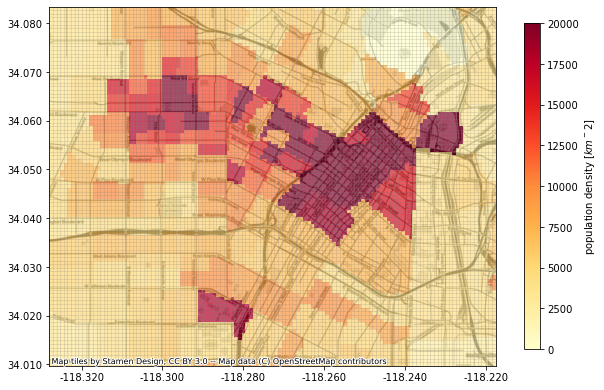

In [33]:
# Daytime population density
extent = grid.total_bounds
ax = ahf_pop_gridded.plot(figsize=(10,10), column='pop_dens_1', alpha=0.7, legend=True, 
              cmap='YlOrRd', vmin=0, vmax=20000, 
              legend_kwds={'label':'population density [$km^-2$]', 'shrink': 0.6})

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, 
                crs = ahf_pop_gridded.crs) # notice the crs must match between basemap and data
grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)

<AxesSubplot:>

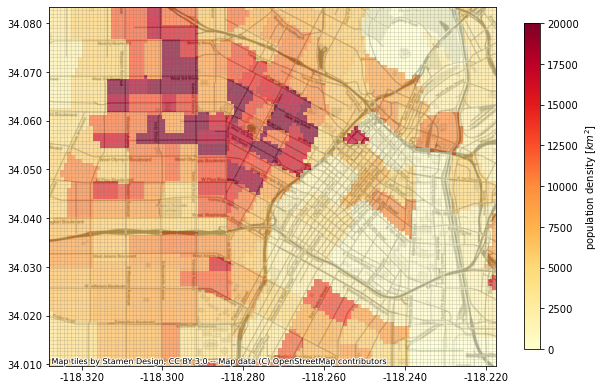

In [35]:
# Nighttime population density
extent = grid.total_bounds
ax = ahf_pop_gridded.plot(figsize=(10,10), column= 'pop_densit', alpha=0.7, legend=True, 
              cmap='YlOrRd', vmin=0, vmax=20000, 
              legend_kwds={'label':'population density [$km^2$]', 'shrink': 0.6})

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, 
                crs = ahf_pop_gridded.crs) # notice the crs must match between basemap and data
grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)

In [36]:
# Calculate daytime and nighttime AHF
# nighttime metabolic rate = 75 W
# daytime metabolic rate = 175W
ahf_pop_gridded['ahf_day'] = (ahf_pop_gridded['pop_dens_1']*175)/(10**6)
ahf_pop_gridded['ahf_night'] = (ahf_pop_gridded['pop_densit']*75)/(10**6)

<AxesSubplot:>

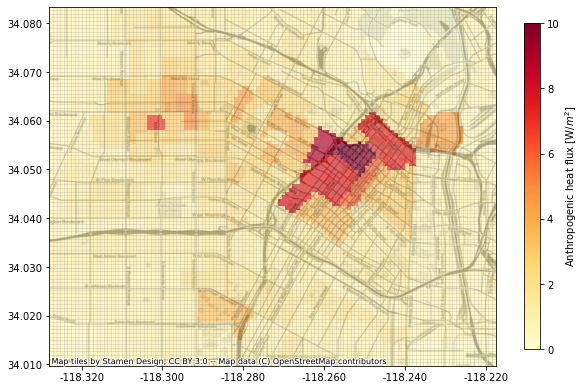

In [37]:
# Daytime ahf_pop
extent = grid.total_bounds
ax = ahf_pop_gridded.plot(figsize=(10,10), column='ahf_day', alpha=0.7, legend=True, 
              cmap='YlOrRd', vmin=0, vmax=10, 
              legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]', 'shrink': 0.6})

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, 
                crs = ahf_pop_gridded.crs) # notice the crs must match between basemap and data
grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)

<AxesSubplot:>

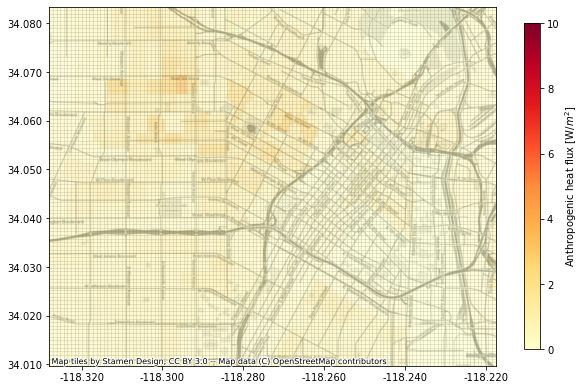

In [38]:
# Nighttime ahf_pop
extent = grid.total_bounds
ax = ahf_pop_gridded.plot(figsize=(10,10), column='ahf_night', alpha=0.7, legend=True, 
              cmap='YlOrRd', vmin=0, vmax=10, 
              legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]', 'shrink': 0.6})

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, 
                crs = ahf_pop_gridded.crs) # notice the crs must match between basemap and data
grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)

In [41]:
ahf_pop_gridded.drop(columns = ['index_right'], inplace=True)
ahf_pop_masked = ahf_pop_gridded.sjoin(central_la_mask, how = 'inner')
# mask the grid with central la boundary
grid_masked = grid.sjoin(central_la_mask, how = 'inner')

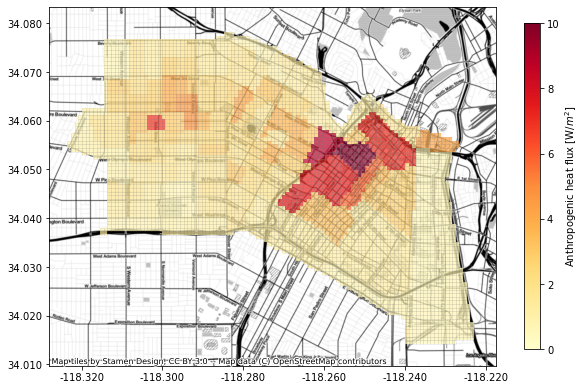

In [46]:
# Daytime ahf_pop
extent = grid.total_bounds
ax = ahf_pop_masked.plot(figsize=(10,10), column='ahf_day', alpha=0.7, legend=True, 
              cmap='YlOrRd', vmin=0, vmax=10, 
              legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]', 'shrink': 0.6})

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, 
                crs = ahf_pop_gridded.crs) # notice the crs must match between basemap and data
grid_masked.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)

plt.savefig('ahf_pop_day.jpg')

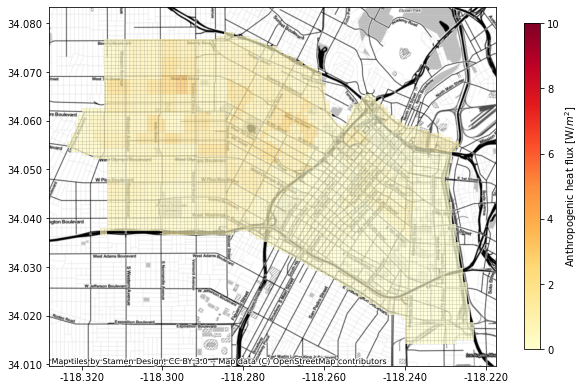

In [47]:
# Nighttime ahf_pop
extent = grid.total_bounds
ax = ahf_pop_masked.plot(figsize=(10,10), column='ahf_night', alpha=0.7, legend=True, 
              cmap='YlOrRd', vmin=0, vmax=10, 
              legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]', 'shrink': 0.6})

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, 
                crs = ahf_pop_gridded.crs) # notice the crs must match between basemap and data
grid_masked.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)

plt.savefig('ahf_pop_night.jpg')